## This is an algorithm development playground for UBS Quant contest

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Concatenate
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, merge, Input, concatenate, Reshape, add
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_update_rate(df, n=5):
    update_rate = []
    for i in range(len(df.columns)):
        counter_start = 0
        min_counter = len(df) + 1
        for j in range(n): # go for n loops to verify the update rate
            counter = 0
            start = df.iloc[counter_start, i]
            while True:
                counter += 1
                if not start == df.iloc[counter_start+counter, i]:
                    break
            counter_start = counter + counter_start
            if counter < min_counter:
                min_counter = counter
            if counter_start >= len(df):
                break
        update_rate.append(min_counter)
    return update_rate

In [56]:
def windowed_return_rate(df, window_size=14, thresh=0.005):
    """
    use the mean of this window_size, and previous window_size to calcualte a stablized return rate
    
    the start_index is window_size
    """
    out = df.copy()
    
    counter = 0
    for i in range(window_size, len(df)-window_size):
        prev_mean = df.iloc[i-window_size:i, :].mean()
        cur_mean = df.iloc[i:i+window_size, :].mean()
        cur_row = (cur_mean - prev_mean) / prev_mean
        
        if not (cur_row <= 2).all() or not (cur_row > -0.8).all(): # use the most recent good row as cur row, if bad data
            cur_row = good_row
        else: # update good row if not bad data
            good_row = cur_row
            
        # updata data
        out.iloc[counter, :] = cur_row
        
        # updata counter
        counter += 1
        
    # discretize data
    out[out > thresh] = 2
    out[abs(out) <= thresh] = 1
    out[out < -thresh] = 0
    
    return out.iloc[window_size:counter, :], window_size

def min_max_average(df, window_size=600):
    """
    use the min and max of the window_size days of data in df to normalize the window_size data.
    this method is running the risk of incorporating future data to the past, but we will see
    
    return the processed df and the start index
    """
    df = df.copy()
    
    for i in range(0, len(df), window_size):
        # find local min max
        dmax = df.iloc[i:i+window_size, :].max()
        dmin = df.iloc[i:i+window_size, :].min()
        
        # normalize data
        df.iloc[i:i+window_size, :] -= dmin
        df.iloc[i:i+window_size, :] /= dmax - dmin
        
    if len(df)%window_size >= window_size / 2:
        # deal with residuals
        # find local min max
        dmax = df.iloc[i-window_size:, :].max()
        dmin = df.iloc[i-window_size:, :].min()

        # normalize data
        df.iloc[i-window_size, :] -= dmin
        df.iloc[i-window_size, :] /= dmax - dmin
        
        return df, 0
    
    return df.iloc[:-(len(df)%window_size), :], 0

In [50]:
# read the factor time data
df = pd.read_csv("Dataset_1003.csv", index_col=[0])

# seperate S&P label out
target = df.iloc[:, :4]
df = df.iloc[:, 4:] # preserve them as the input data

# collect col index for daily updated factors and quarterly updated factors
rate = get_update_rate(df)
slow_update_index = [i for i, r in enumerate(rate) if r > 1 and i not in [df.columns.get_loc('Change in private inventories')]]
quick_update_index = [i for i, r in enumerate(rate) if r == 1 and i not in [df.columns.get_loc("__SIC1_D_High")]]

# seperate slowly updated factor and quickly updated factor
slow_factor_df = df.iloc[:, slow_update_index]
quick_factor_df = df.iloc[:, quick_update_index]

# process target
target, target_start_index = moving_average_then_sigmoid_normalization(target, window_size=5, decimal_move=3)

# process label
label, label_start_index = windowed_return_rate(target, window_size=10)

# process fast updated factor
quick_factor_df, quick_start_index = min_max_average(quick_factor_df, window_size=3000)

# process slowly updated factor
slow_factor_df, slow_start_index = min_max_average(slow_factor_df, window_size=3000)

# determine which row to start with and remove earlier rows
start_index = max(slow_start_index, quick_start_index, label_start_index, target_start_index)
target = target.iloc[start_index:, :]
label = label.iloc[start_index-label_start_index:, :]
quick_factor_df = quick_factor_df.iloc[start_index-quick_start_index:, :]
slow_factor_df = slow_factor_df.iloc[start_index-slow_start_index:, :]

# remove later rows to have same length data
length = min(len(target), len(label), len(quick_factor_df), len(slow_factor_df))
target = target.iloc[:length, :]
label = label.iloc[:length, :]
quick_factor_df = quick_factor_df.iloc[:length, :]
slow_factor_df = slow_factor_df.iloc[:length, :]

              Open         High          Low        Close
count  4528.000000  4528.000000  4528.000000  4528.000000
mean   1435.382970  1443.782652  1426.367407  1435.602265
std     429.306643   428.933676   429.679515   429.481633
min     679.280000   695.270000   666.790000   676.530000
25%    1134.545075  1142.180100  1126.637500  1134.425075
50%    1315.950000  1324.425000  1307.690000  1315.410000
75%    1649.520000  1656.675000  1639.840000  1650.480000
max    2692.710000  2694.970000  2685.920000  2690.160000


In [51]:
target

,Open,High,Low,Close
Date,,,,
2000/1/24,0.863893,0.861674,0.819911,0.815872
2000/1/25,0.816992,0.816273,0.812112,0.825437
2000/1/26,0.821475,0.814309,0.825222,0.818753
2000/1/27,0.822434,0.821598,0.803167,0.812530
2000/1/28,0.811765,0.798449,0.775710,0.769316
2000/1/31,0.768454,0.793840,0.768857,0.807916
2000/2/1,0.808716,0.814378,0.807904,0.824593
2000/2/2,0.823473,0.823392,0.828665,0.824413
2000/2/3,0.828226,0.829352,0.823399,0.842250


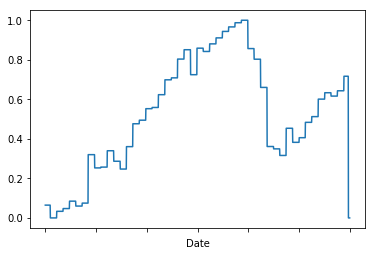

In [49]:
slow_factor_df.iloc[:3000, 3].plot()

In [5]:
# data generator for training and validation of stateless lstm
def generate_train_data(df, label, test_split=0.2, valid_split=0.1, seq_len=365):
    # prepare output
    out = {}
    
    # print out data information
    for i in df:
        print(len(i.columns), end=", ")
    print()
    for i in df:
        print(len(i), end=", ")
    
    # get shortest data length (assuming all data start at the same time)
    data_len = len(df[0])-seq_len
    test_split_len = int(data_len*(1-test_split-valid_split))
    valid_split_len = int(data_len*(1-valid_split))
    
    # create feature sequence
    for i in range(len(df)):
        df[i] = np.array([np.array(df[i].iloc[j:j+seq_len, :]) for j in range(data_len)])
        out["train_df" + str(i)] = df[i][:test_split_len]
        out["test_df" + str(i)] = df[i][test_split_len:valid_split_len]
        out["valid_df" + str(i)] = df[i][valid_split_len:]
    
    # create label sequence
    label = np.array([np.array(label.iloc[i+seq_len, :]) for i in range(data_len)]) # watch out for the shift here
    
    # convert label to categorical format
    label = label.T
    for i in range(4):
        new_label = to_categorical(label[i], num_classes=3)
        out["train_label"+str(i)] = new_label[:test_split_len]
        out["test_label"+str(i)] = new_label[test_split_len:valid_split_len]
        out["valid_label"+str(i)] = new_label[valid_split_len:]
        
    return out

In [6]:
# generate data
seq_len = 100
train_data = generate_train_data([slow_factor_df, quick_factor_df, target], 
                                 label, seq_len=seq_len, test_split=0.2, valid_split=0.1)

25, 18, 4, 
4338, 4338, 4338, 

In [7]:
# flow for prev_label_input
prev_target_input = Input(shape=(seq_len, 4))
x = LSTM(units=64, dropout=0.2, activation="relu", kernel_regularizer=l2(l=0.01), return_sequences=False)(prev_target_input)
x = Dense(units=128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output1 = Dense(units=3, activation="softmax")(x)
output2 = Dense(units=3, activation="softmax")(x)
output3 = Dense(units=3, activation="softmax")(x)
output4 = Dense(units=3, activation="softmax")(x)

# compile model
Indexer = Model(inputs=[prev_target_input], outputs=[output1, output2, output3, output4])
Indexer.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["categorical_crossentropy"])

# display model
plot_model(model=Indexer, to_file="temp.png")
Indexer.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 4)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 64)           17664       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          8320        lstm_1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128)          512      

In [8]:
valid_output = [train_data['test_label0'], train_data['test_label1'], train_data['test_label2'], train_data['test_label3']]
train_output = [train_data['train_label0'], train_data['train_label1'], train_data['train_label2'], train_data['train_label3']]

Indexer.fit(x=train_data["train_df2"], y=train_output, 
            validation_data=[train_data["test_df2"], valid_output],
            epochs=300, batch_size=64, shuffle=True, verbose=1)


Train on 2966 samples, validate on 848 samples
Epoch 1/300
2966/2966 [==============================] - 5s 2ms/step - loss: 4.3603 - dense_2_loss: 1.0791 - dense_3_loss: 1.0684 - dense_4_loss: 1.0708 - dense_5_loss: 1.0765 - dense_2_categorical_crossentropy: 1.0791 - dense_3_categorical_crossentropy: 1.0684 - dense_4_categorical_crossentropy: 1.0708 - dense_5_categorical_crossentropy: 1.0765 - val_loss: 3.8230 - val_dense_2_loss: 0.9605 - val_dense_3_loss: 0.9158 - val_dense_4_loss: 0.9605 - val_dense_5_loss: 0.9317 - val_dense_2_categorical_crossentropy: 0.9605 - val_dense_3_categorical_crossentropy: 0.9158 - val_dense_4_categorical_crossentropy: 0.9605 - val_dense_5_categorical_crossentropy: 0.9317
Epoch 2/300
2966/2966 [==============================] - 5s 2ms/step - loss: 3.5019 - dense_2_loss: 0.8788 - dense_3_loss: 0.8487 - dense_4_loss: 0.8687 - dense_5_loss: 0.8584 - dense_2_categorical_crossentropy: 0.8788 - dense_3_categorical_crossentropy: 0.8487 - dense_4_categorical_crosse

2966/2966 [==============================] - 5s 2ms/step - loss: 2.9562 - dense_2_loss: 0.7337 - dense_3_loss: 0.7401 - dense_4_loss: 0.7319 - dense_5_loss: 0.7378 - dense_2_categorical_crossentropy: 0.7337 - dense_3_categorical_crossentropy: 0.7401 - dense_4_categorical_crossentropy: 0.7319 - dense_5_categorical_crossentropy: 0.7378 - val_loss: 2.9404 - val_dense_2_loss: 0.7300 - val_dense_3_loss: 0.7057 - val_dense_4_loss: 0.7627 - val_dense_5_loss: 0.7296 - val_dense_2_categorical_crossentropy: 0.7300 - val_dense_3_categorical_crossentropy: 0.7057 - val_dense_4_categorical_crossentropy: 0.7627 - val_dense_5_categorical_crossentropy: 0.7296
Epoch 14/300
2966/2966 [==============================] - 5s 2ms/step - loss: 2.9529 - dense_2_loss: 0.7310 - dense_3_loss: 0.7381 - dense_4_loss: 0.7346 - dense_5_loss: 0.7371 - dense_2_categorical_crossentropy: 0.7310 - dense_3_categorical_crossentropy: 0.7381 - dense_4_categorical_crossentropy: 0.7346 - dense_5_categorical_crossentropy: 0.7371 

2966/2966 [==============================] - 5s 2ms/step - loss: 2.9408 - dense_2_loss: 0.7301 - dense_3_loss: 0.7389 - dense_4_loss: 0.7304 - dense_5_loss: 0.7326 - dense_2_categorical_crossentropy: 0.7301 - dense_3_categorical_crossentropy: 0.7389 - dense_4_categorical_crossentropy: 0.7304 - dense_5_categorical_crossentropy: 0.7326 - val_loss: 2.8833 - val_dense_2_loss: 0.7178 - val_dense_3_loss: 0.6926 - val_dense_4_loss: 0.7486 - val_dense_5_loss: 0.7154 - val_dense_2_categorical_crossentropy: 0.7178 - val_dense_3_categorical_crossentropy: 0.6926 - val_dense_4_categorical_crossentropy: 0.7486 - val_dense_5_categorical_crossentropy: 0.7154
Epoch 26/300
2966/2966 [==============================] - 5s 2ms/step - loss: 2.9234 - dense_2_loss: 0.7245 - dense_3_loss: 0.7344 - dense_4_loss: 0.7266 - dense_5_loss: 0.7290 - dense_2_categorical_crossentropy: 0.7245 - dense_3_categorical_crossentropy: 0.7344 - dense_4_categorical_crossentropy: 0.7266 - dense_5_categorical_crossentropy: 0.7290 

2966/2966 [==============================] - 5s 2ms/step - loss: 2.8953 - dense_2_loss: 0.7171 - dense_3_loss: 0.7277 - dense_4_loss: 0.7193 - dense_5_loss: 0.7231 - dense_2_categorical_crossentropy: 0.7171 - dense_3_categorical_crossentropy: 0.7277 - dense_4_categorical_crossentropy: 0.7193 - dense_5_categorical_crossentropy: 0.7231 - val_loss: 2.8426 - val_dense_2_loss: 0.7079 - val_dense_3_loss: 0.6841 - val_dense_4_loss: 0.7385 - val_dense_5_loss: 0.7041 - val_dense_2_categorical_crossentropy: 0.7079 - val_dense_3_categorical_crossentropy: 0.6841 - val_dense_4_categorical_crossentropy: 0.7385 - val_dense_5_categorical_crossentropy: 0.7041
Epoch 38/300
2966/2966 [==============================] - 5s 2ms/step - loss: 2.8925 - dense_2_loss: 0.7185 - dense_3_loss: 0.7256 - dense_4_loss: 0.7173 - dense_5_loss: 0.7231 - dense_2_categorical_crossentropy: 0.7185 - dense_3_categorical_crossentropy: 0.7256 - dense_4_categorical_crossentropy: 0.7173 - dense_5_categorical_crossentropy: 0.7231 

2966/2966 [==============================] - 5s 2ms/step - loss: 2.8992 - dense_2_loss: 0.7194 - dense_3_loss: 0.7287 - dense_4_loss: 0.7181 - dense_5_loss: 0.7252 - dense_2_categorical_crossentropy: 0.7194 - dense_3_categorical_crossentropy: 0.7287 - dense_4_categorical_crossentropy: 0.7181 - dense_5_categorical_crossentropy: 0.7252 - val_loss: 2.8288 - val_dense_2_loss: 0.7038 - val_dense_3_loss: 0.6827 - val_dense_4_loss: 0.7330 - val_dense_5_loss: 0.7012 - val_dense_2_categorical_crossentropy: 0.7038 - val_dense_3_categorical_crossentropy: 0.6827 - val_dense_4_categorical_crossentropy: 0.7330 - val_dense_5_categorical_crossentropy: 0.7012
Epoch 50/300
2966/2966 [==============================] - 5s 2ms/step - loss: 2.8941 - dense_2_loss: 0.7174 - dense_3_loss: 0.7276 - dense_4_loss: 0.7173 - dense_5_loss: 0.7238 - dense_2_categorical_crossentropy: 0.7174 - dense_3_categorical_crossentropy: 0.7276 - dense_4_categorical_crossentropy: 0.7173 - dense_5_categorical_crossentropy: 0.7238 

2966/2966 [==============================] - 5s 2ms/step - loss: 2.8744 - dense_2_loss: 0.7130 - dense_3_loss: 0.7220 - dense_4_loss: 0.7128 - dense_5_loss: 0.7190 - dense_2_categorical_crossentropy: 0.7130 - dense_3_categorical_crossentropy: 0.7220 - dense_4_categorical_crossentropy: 0.7128 - dense_5_categorical_crossentropy: 0.7190 - val_loss: 2.8769 - val_dense_2_loss: 0.7156 - val_dense_3_loss: 0.6943 - val_dense_4_loss: 0.7459 - val_dense_5_loss: 0.7133 - val_dense_2_categorical_crossentropy: 0.7156 - val_dense_3_categorical_crossentropy: 0.6943 - val_dense_4_categorical_crossentropy: 0.7459 - val_dense_5_categorical_crossentropy: 0.7133
Epoch 62/300
2966/2966 [==============================] - 5s 2ms/step - loss: 2.8812 - dense_2_loss: 0.7147 - dense_3_loss: 0.7241 - dense_4_loss: 0.7126 - dense_5_loss: 0.7220 - dense_2_categorical_crossentropy: 0.7147 - dense_3_categorical_crossentropy: 0.7241 - dense_4_categorical_crossentropy: 0.7126 - dense_5_categorical_crossentropy: 0.7220 

2966/2966 [==============================] - 5s 2ms/step - loss: 2.8778 - dense_2_loss: 0.7127 - dense_3_loss: 0.7221 - dense_4_loss: 0.7128 - dense_5_loss: 0.7221 - dense_2_categorical_crossentropy: 0.7127 - dense_3_categorical_crossentropy: 0.7221 - dense_4_categorical_crossentropy: 0.7128 - dense_5_categorical_crossentropy: 0.7221 - val_loss: 2.9412 - val_dense_2_loss: 0.7316 - val_dense_3_loss: 0.7088 - val_dense_4_loss: 0.7639 - val_dense_5_loss: 0.7286 - val_dense_2_categorical_crossentropy: 0.7316 - val_dense_3_categorical_crossentropy: 0.7088 - val_dense_4_categorical_crossentropy: 0.7639 - val_dense_5_categorical_crossentropy: 0.7286
Epoch 74/300
2966/2966 [==============================] - 5s 2ms/step - loss: 2.8525 - dense_2_loss: 0.7072 - dense_3_loss: 0.7155 - dense_4_loss: 0.7082 - dense_5_loss: 0.7134 - dense_2_categorical_crossentropy: 0.7072 - dense_3_categorical_crossentropy: 0.7155 - dense_4_categorical_crossentropy: 0.7082 - dense_5_categorical_crossentropy: 0.7134 

2966/2966 [==============================] - 5s 2ms/step - loss: 2.8632 - dense_2_loss: 0.7099 - dense_3_loss: 0.7200 - dense_4_loss: 0.7094 - dense_5_loss: 0.7156 - dense_2_categorical_crossentropy: 0.7099 - dense_3_categorical_crossentropy: 0.7200 - dense_4_categorical_crossentropy: 0.7094 - dense_5_categorical_crossentropy: 0.7156 - val_loss: 2.9728 - val_dense_2_loss: 0.7397 - val_dense_3_loss: 0.7163 - val_dense_4_loss: 0.7712 - val_dense_5_loss: 0.7373 - val_dense_2_categorical_crossentropy: 0.7397 - val_dense_3_categorical_crossentropy: 0.7163 - val_dense_4_categorical_crossentropy: 0.7712 - val_dense_5_categorical_crossentropy: 0.7373
Epoch 86/300
2966/2966 [==============================] - 5s 2ms/step - loss: 2.8749 - dense_2_loss: 0.7112 - dense_3_loss: 0.7212 - dense_4_loss: 0.7150 - dense_5_loss: 0.7195 - dense_2_categorical_crossentropy: 0.7112 - dense_3_categorical_crossentropy: 0.7212 - dense_4_categorical_crossentropy: 0.7150 - dense_5_categorical_crossentropy: 0.7195 

2966/2966 [==============================] - 5s 2ms/step - loss: 2.8448 - dense_2_loss: 0.7062 - dense_3_loss: 0.7154 - dense_4_loss: 0.7046 - dense_5_loss: 0.7101 - dense_2_categorical_crossentropy: 0.7062 - dense_3_categorical_crossentropy: 0.7154 - dense_4_categorical_crossentropy: 0.7046 - dense_5_categorical_crossentropy: 0.7101 - val_loss: 3.0315 - val_dense_2_loss: 0.7543 - val_dense_3_loss: 0.7317 - val_dense_4_loss: 0.7856 - val_dense_5_loss: 0.7514 - val_dense_2_categorical_crossentropy: 0.7543 - val_dense_3_categorical_crossentropy: 0.7317 - val_dense_4_categorical_crossentropy: 0.7856 - val_dense_5_categorical_crossentropy: 0.7514
Epoch 98/300
2966/2966 [==============================] - 5s 2ms/step - loss: 2.9035 - dense_2_loss: 0.7216 - dense_3_loss: 0.7305 - dense_4_loss: 0.7175 - dense_5_loss: 0.7253 - dense_2_categorical_crossentropy: 0.7216 - dense_3_categorical_crossentropy: 0.7305 - dense_4_categorical_crossentropy: 0.7175 - dense_5_categorical_crossentropy: 0.7253 

KeyboardInterrupt: 

### Currently the system is overfitting to the average
### The following methods are to be attempted
1. Try to remove corelated input features
2. Simplify the current network in a proper way

In [9]:
def to_discrete(prob):
    prob = prob.copy()
    for i in range(prob.shape[0]):
        arg = prob[i, :].argmax()
        prob[i, :] = np.zeros(3)
        prob[i, arg] = 1
    return prob

def to_class(cate):
    tmp = np.array([-1, 0, 1]).reshape((3, 1))
    return cate.dot(tmp).T.reshape((-1))

def compare_output(predicted, correct):
    correct = to_class(correct)
    predicted = to_class(to_discrete(predicted))
    x = np.arange(0, correct.shape[0])
    plt.figure(figsize=(22, 2))
    plt.plot(x, correct)
    plt.plot(x, predicted)

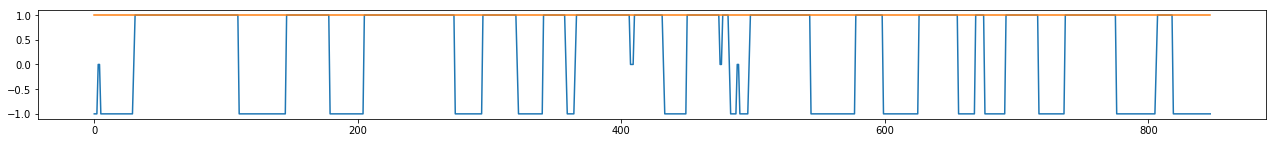

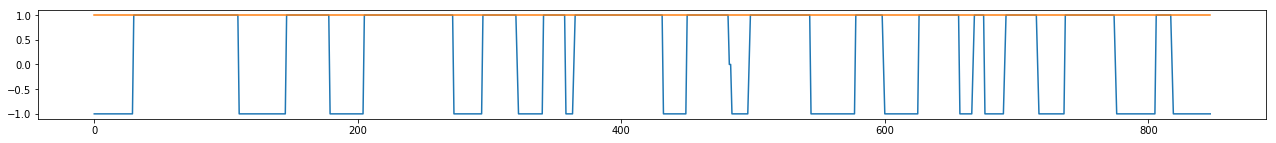

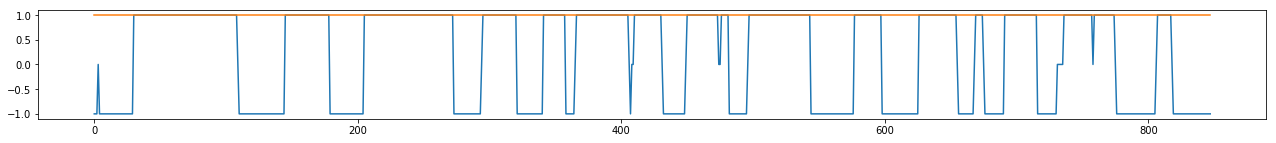

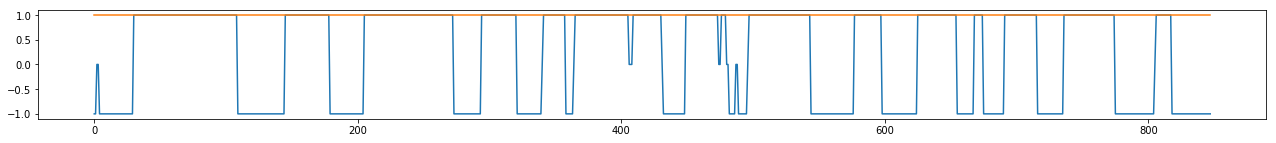

In [10]:
for i in range(4):
    which = "test"
    which_output = i
    predicted = Indexer.predict_on_batch([train_data[which+'_df2']])
    predicted = predicted[which_output]
    correct = train_data[which+"_label"+str(which_output)]
    compare_output(predicted, correct)